# Lesson 12 - Example: Gapminder Dataset

## Introduction 

In this lesson, we will be working with the Gapminder dataset, which contains socioeconomic data for 184 countries. The dataset contains information about each country, collected (or estimated) for every year from 1800 to 2018. Each record within the dataset contains the following peices of information: **country**, **continent**, **year**, **population**, **life expectancy**, **per capita GDP**, and **gini score**.

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Load and Explore Data

We will load the data from a text file, and will examine its contents.

In [0]:
gm_raw = sc.textFile('FileStore/tables/gapminder_data.txt')
for row in gm_raw.take(5):
    print(row)

country	year	continent	population	life_exp	gdp_per_cap	gini
Afghanistan	1800	asia	3280000	28.2	603	30.5
Albania	1800	europe	410000	35.4	667	38.9
Algeria	1800	africa	2500000	28.8	715	56.2
Angola	1800	africa	1570000	27	618	57.2

We will start by processing the dataset. We will filter out the header row and will process each other line by tokenizing the string and coercing each value into the appropriate datatype. We will return the results in the form of a list of values.

In [0]:
header = gm_raw.take(1)[0].split('\t')

def process_row(row):
    tokens = row.split('\t')
    return (tokens[0], int(tokens[1]), tokens[2], int(tokens[3]), 
            float(tokens[4]), int(tokens[5]), float(tokens[6]))

gm = (gm_raw
      .filter(lambda x : 'country' not in x)
      .map(process_row))

for row in gm.take(5):
    print(row)

('Afghanistan', 1800, 'asia', 3280000, 28.2, 603, 30.5)
('Albania', 1800, 'europe', 410000, 35.4, 667, 38.9)
('Algeria', 1800, 'africa', 2500000, 28.8, 715, 56.2)
('Angola', 1800, 'africa', 1570000, 27.0, 618, 57.2)
('Antigua and Barbuda', 1800, 'americas', 37000, 33.5, 757, 40.0)

Let's see how many records are present in the dataset.

In [0]:
gm.count()

Out[5]: 40296

For this example, we will be working with only the most recent data represented in the dataset. Let's find the latest year for which we have data.

In [0]:
# Find the latest year in the data. 
print(gm.map(lambda x : x[1]).max())

2018

We will now use `filter()` to keep only the records from 2018.

In [0]:
gm_18 = gm.filter(lambda x : x[1] == 2018)
gm_18.persist()
gm_18.count()

Out[7]: 184

## Largest and Smallest Populations

We will apply pair RDD tools to find the countries with the largest and smallest populations in 2018.

In [0]:
print('Largest Populations in 2018')
print('-' * 40)
for row in gm_18.sortBy(lambda x : x[3], ascending=False).take(10):
    print(f'{row[0]:<30}{row[3]:>10}')


Largest Populations in 2018
----------------------------------------
China 1420000000
India 1350000000
United States 327000000
Indonesia 267000000
Brazil 211000000
Pakistan 201000000
Nigeria 196000000
Bangladesh 166000000
Russia 144000000
Mexico 131000000

In [0]:
print('Smallest Populations in 2018')
print('-' * 40)
for row in gm_18.sortBy(lambda x : x[3]).take(10):
    print(f'{row[0]:<30}{row[3]:>10}')

Smallest Populations in 2018
----------------------------------------
Seychelles 95200
Antigua and Barbuda 103000
Micronesia, Fed. Sts. 106000
Grenada 108000
Tonga 109000
St. Vincent and the Grenadines 110000
Kiribati 118000
St. Lucia 180000
Samoa 198000
Sao Tome and Principe 209000

## Highest and Lowest Life Expectancy


We will apply pair RDD tools to find the countries with the highest and lowest life expectancies in 2018.

In [0]:
print('Highest Life Expectancy in 2018')
print('-' * 40)
for row in gm_18.sortBy(lambda x : x[4], ascending=False).take(10):
    print(f'{row[0]:<30}{row[4]:>10}')

Highest Life Expectancy in 2018
----------------------------------------
Japan 84.2
Singapore 84.0
Switzerland 83.5
Spain 83.2
Australia 82.9
France 82.6
Iceland 82.6
Italy 82.6
Israel 82.4
Luxembourg 82.4

In [0]:
print('Lowest Life  Expectancy in 2018')
print('-' * 40)
for row in gm_18.sortBy(lambda x : x[4]).take(10):
    print(f'{row[0]:<30}{row[4]:>10}')

Lowest Life Expectancy in 2018
----------------------------------------
Lesotho 51.1
Central African Republic 51.6
Somalia 58.0
Swaziland 58.6
Afghanistan 58.7
Zambia 59.5
Guinea-Bissau 59.7
Sierra Leone 60.0
Zimbabwe 60.2
Chad 60.5

## Calculating GDP

In the next cell, we calculate the GDP for each country, creating a new RDD that contains this information.

In [0]:
gm_18_gdp = gm_18.map(lambda x : (x[0], x[2], x[3], x[5], x[3] * x[5]) )

print(f'{"Country":<24}{"Continent":<12}{"Population":>12}{"pcGDP":>10}{"GDP":>16}')
print('-' * 74)

for row in gm_18_gdp.take(5):
    print(f'{row[0]:<24}{row[1]:<12}{row[2]:>12}{row[3]:>10}{row[4]:>16}')


Country Continent Population pcGDP GDP
--------------------------------------------------------------------------
Afghanistan asia 36400000 1870 68068000000
Albania europe 2930000 12400 36332000000
Algeria africa 42000000 13700 575400000000
Angola africa 30800000 5850 180180000000
Antigua and Barbuda americas 103000 21000 2163000000

In [0]:
print(header)

['country', 'year', 'continent', 'population', 'life_exp', 'gdp_per_cap', 'gini']

## Population, Life Expectancy, and GDP by Continent

In the cell below, we will use pair RDD methods to determine the total population, life expectancy, and per capita GDP for each continental region in the dataset. An explanation of the purpose of the methods used in this example is as follows:

* The first `map()` method produces a pair RDD with elements of the following form: `(continent, [population, pop_weighted_life_exp, total_gdp])`
* The `reduceByKey()` method produces a pair RDD with elements of the following form: `(continent, [total_population, pop_weighted_life_exp, total_gdp])`
* The `mapValues()` method produces a pair RDD with elements of the following form: `(continent, [total_population, life_exp, per_cap_gdp])`
* The last `map()` method "flattens" the pair RDD into an RDD of lists with the following form: `(continent, total_population, life_exp, per_cap_gdp)`

In [0]:
for item in gm_18.take(5):
    print(item)

('Afghanistan', 2018, 'asia', 36400000, 58.7, 1870, 36.8)
('Albania', 2018, 'europe', 2930000, 78.0, 12400, 29.0)
('Algeria', 2018, 'africa', 42000000, 77.9, 13700, 27.6)
('Angola', 2018, 'africa', 30800000, 65.2, 5850, 42.6)
('Antigua and Barbuda', 2018, 'americas', 103000, 77.6, 21000, 40.0)

In [0]:
temp = (
    gm_18
    .map(lambda x : (x[2], (x[3], x[4], 1) ) )
    .reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1], x[2] + y[2]) )
    .map(lambda x : (x[0], x[1][2], round(x[1][0] / x[1][2],2), round(x[1][1] / x[1][2],2) ) )    
    # (continent, count, avg_pop, avg_life_exp)
    
)

for item in temp.take(5):
    print(item)

('europe', 44, 19135431.82, 78.72)
('africa', 54, 23836114.81, 65.24)
('asia', 53, 84058735.85, 73.21)
('americas', 33, 30635696.97, 75.83)

In [0]:
temp = (
    gm_18
    .map(lambda x : (x[2], (x[3], x[4], 1) ) )
    .reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1], x[2] + y[2]) )
    .mapValues(lambda x : (x[2], round(x[0]/x[2],2) , round(x[1]/x[2],2) ))
    .map(lambda x : (x[0], x[1][0], x[1][1], x[1][2]))
)

for item in temp.take(5):
    print(item)

('europe', 44, 19135431.82, 78.72)
('africa', 54, 23836114.81, 65.24)
('asia', 53, 84058735.85, 73.21)
('americas', 33, 30635696.97, 75.83)

In [0]:
grouped_results = (
    gm_18
    .map(lambda x : (x[2] ,[x[3], x[3] * x[5], x[3] * x[4]] ))
    .reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1], x[2] + y[2]) )
    .mapValues(lambda x : [x[0], int(x[1]/x[0]), round(x[2]/x[0], 1)])
    .map(lambda x : [x[0]] + x[1])
)

grouped_list = grouped_results.collect()

for row in grouped_list:
    print(row)

['europe', 841959000, 31533, 78.4]
['africa', 1287150200, 4699, 65.9]
['asia', 4455113000, 12705, 73.2]
['americas', 1010978000, 28708, 77.5]

## Plotting Results by Continent

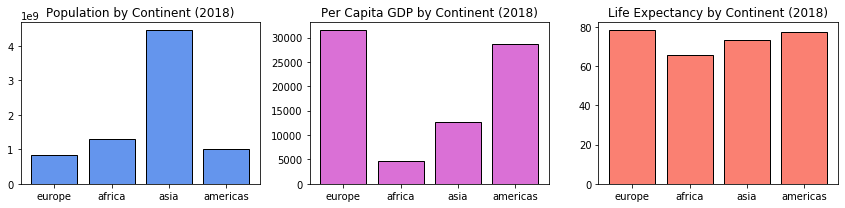

In [0]:
df = pd.DataFrame(grouped_list, columns=['continent', 'population', 'pcgdp', 'life_exp'])

plt.figure(figsize=[12,3])

plt.subplot(1,3,1)
plt.bar(df.continent, df.population, color='cornflowerblue', edgecolor='k')
plt.title('Population by Continent (2018)')

plt.subplot(1,3,2)
plt.bar(df.continent, df.pcgdp, color='orchid', edgecolor='k')
plt.title('Per Capita GDP by Continent (2018)')

plt.subplot(1,3,3)
plt.bar(df.continent, df.life_exp, color='salmon', edgecolor='k')
plt.title('Life Expectancy by Continent (2018)')

plt.tight_layout()
plt.show()